<a href="https://colab.research.google.com/github/tedee09/ats-re604-emnist-letter-classification/blob/main/ats_re604.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ATS RE604 - Computer Vision**


### **NAME  : SEPTEDY INDRAJANNAH**
### **NIM   : 4222211006**
### **CLASS : NIGHT CLASS**



## **1. Load dan Visualisasi Dataset**

In [29]:
# STEP 1 - Load & Visualize Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [30]:
# Load CSV
df = pd.read_csv("emnist-letters-train.csv", header=None)

In [31]:
# Shuffle the data
df = shuffle(df, random_state=42).reset_index(drop=True)

In [32]:
# Separate labels and features
labels = df.iloc[:, 0].values
images = df.iloc[:, 1:].values.reshape(-1, 28, 28)

In [33]:
# Change labels from 1-26 to letters A-Z
label_map = {i: chr(64 + i) for i in range(1, 27)}
labels_char = np.array([label_map[label] for label in labels])

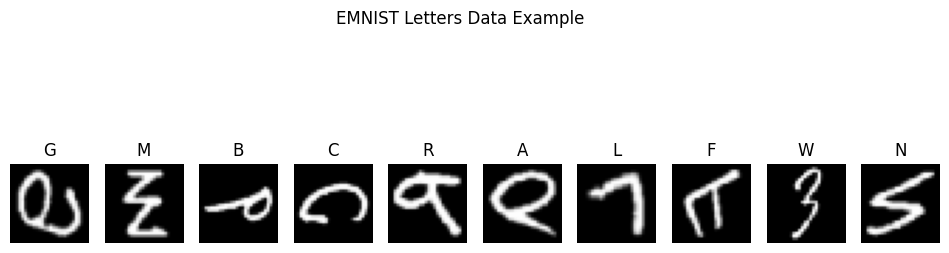

In [50]:
# Show the first 10 images
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(labels_char[i])
    plt.axis("off")
plt.suptitle("EMNIST Letters Data Example")
plt.show()

## **2. Retrieve 100 Data from Each Letter (Total 2600)**

In [35]:
# STEP 2 - Fetch 100 Data per Letter

selected_indices = []
for label in range(1, 27):
    idx = np.where(labels == label)[0][:100]
    selected_indices.extend(idx)

selected_images = images[selected_indices]
selected_labels = labels[selected_indices]
selected_labels_char = labels_char[selected_indices]

## **3. HOG Feature Extraction**

In [36]:
# STEP 3 - HOG Feature Extraction

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

hog_features = []
for img in selected_images:
    feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2), block_norm='L2-Hys')
    hog_features.append(feature)

hog_features = np.array(hog_features)


In [37]:
# Normalize
scaler = StandardScaler()
hog_scaled = scaler.fit_transform(hog_features)

## **4. SVM + Grid Search**

In [38]:
# STEP 4 - SVM Training with Grid Search

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(
    hog_scaled, selected_labels, test_size=0.2, random_state=42, stratify=selected_labels)

param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 0.01],
    'kernel': ['rbf']
}

clf = GridSearchCV(svm.SVC(), param_grid, scoring='accuracy', cv=3)
clf.fit(X_train, y_train)

print("Best Parameters:", clf.best_params_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


## **5. Evaluation Model**

In [39]:
# STEP 5 - Evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8019
Precision: 0.8059
Recall: 0.8019
F1 Score: 0.8006


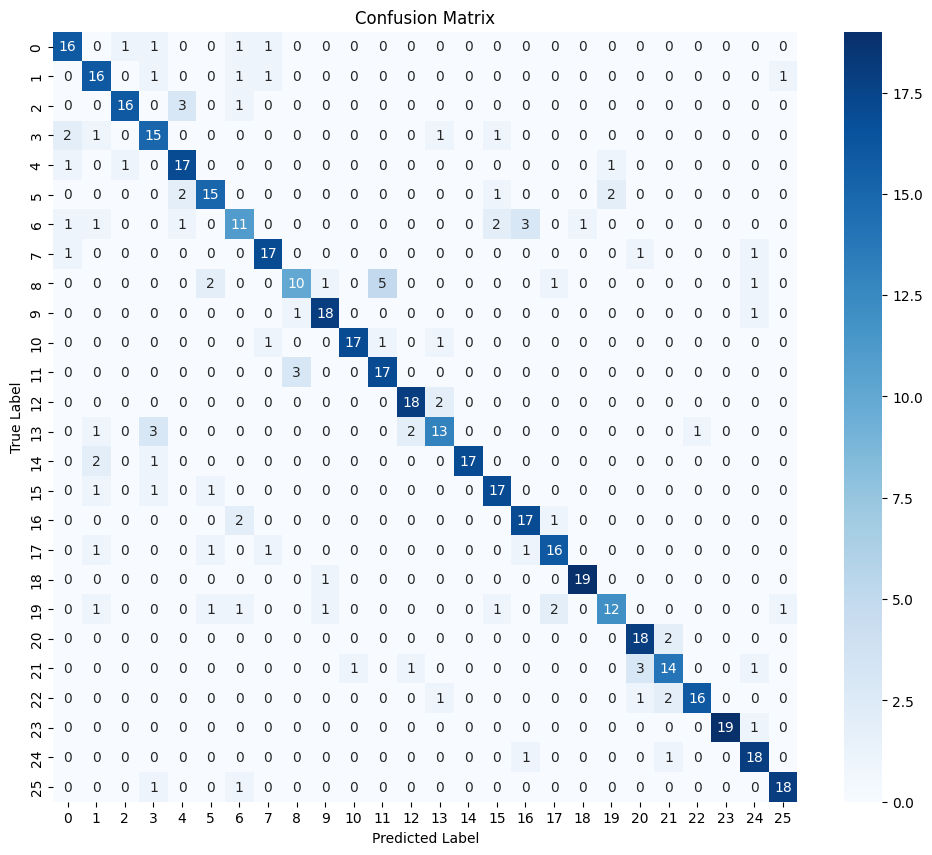

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## **6. Evaluation with Leave-One-Out Cross Validation (LOOCV)**

In [41]:
# STEP 6 - Evaluation with Leave-One-Out Cross Validation (LOOCV)
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report

In [42]:
# Initialize LOOCV
loo = LeaveOneOut()

In [43]:
# Create an SVM model with the best parameters from the previous grid
best_svm = svm.SVC(
    C=clf.best_params_['C'],
    gamma=clf.best_params_['gamma'],
    kernel=clf.best_params_['kernel']
)

y_true_loo = []
y_pred_loo = []

In [44]:
# limit to 520 data only (20 per letter)

sample_indices = []
for label in range(1, 27):
    idx = np.where(selected_labels == label)[0][:20]
    sample_indices.extend(idx)

X_loo = hog_scaled[sample_indices]
y_loo = selected_labels[sample_indices]

In [45]:
# Run LOOCV
for train_idx, test_idx in loo.split(X_loo):
    X_tr, X_te = X_loo[train_idx], X_loo[test_idx]
    y_tr, y_te = y_loo[train_idx], y_loo[test_idx]

    best_svm.fit(X_tr, y_tr)
    pred = best_svm.predict(X_te)

    y_true_loo.append(y_te[0])
    y_pred_loo.append(pred[0])

In [48]:
# LOOCV final evaluation
print("LOOCV evaluation (520 data samples):")
print(f"Accuracy : {accuracy_score(y_true_loo, y_pred_loo):.4f}")
print(f"Precision: {precision_score(y_true_loo, y_pred_loo, average='macro'):.4f}")
print(f"Recall   : {recall_score(y_true_loo, y_pred_loo, average='macro'):.4f}")
print(f"F1 Score : {f1_score(y_true_loo, y_pred_loo, average='macro'):.4f}")

LOOCV evaluation (520 data samples):
Accuracy : 0.6750
Precision: 0.6822
Recall   : 0.6750
F1 Score : 0.6756


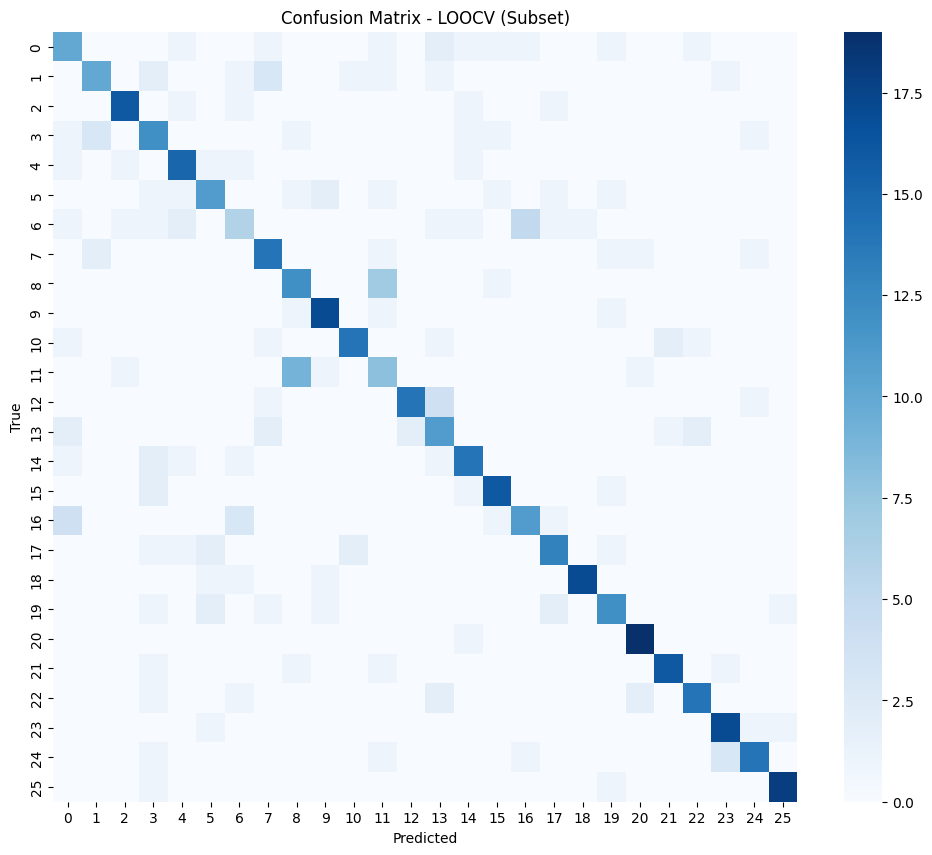

In [49]:
# Confusion matrix
cm_loo = confusion_matrix(y_true_loo, y_pred_loo)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_loo, annot=False, cmap='Blues')
plt.title("Confusion Matrix - LOOCV (Subset)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()